<a href="https://colab.research.google.com/github/wh2353/Detect-tumor-in-gigapixel-pathology-images/blob/main/122421_cancer_image_data_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Part II Modeling












**Installing openslide-tools**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import pathlib
import pickle
import random

In [3]:
%tensorflow_version 2.x
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

**Mount drive / Fetch raw image data**

In [6]:
#append google drive folder to google colab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)


Mounted at /content/drive


**Load train and validate dataset**

In [8]:
#load train data
with open("/content/drive/MyDrive/120319_project_tumor_folder/122421_train_cancer_image_patches.pkl", 'rb') as f:
  train_zoom_level1_result, train_zoom_level2_result, train_label = pickle.load(f)
f.close()

with open("/content/drive/MyDrive/120319_project_tumor_folder/122421_validation_cancer_image_patches.pkl", 'rb') as f:
  val_zoom_level1_result, val_zoom_level2_result, val_label = pickle.load(f)
f.close()

In [9]:
#convert to np array

train_data_level1 = np.array(train_zoom_level1_result)
train_data_level2 = np.array(train_zoom_level2_result)

train_data_label = np.array(train_label)

assert train_data_level1.shape == train_data_level2.shape
assert train_data_label.shape[0] == train_data_level2.shape[0]


val_data_level1 = np.array(val_zoom_level1_result)
val_data_level2 = np.array(val_zoom_level2_result)

val_data_label = np.array(val_label)


assert val_data_level1.shape == val_data_level2.shape
assert val_data_label.shape[0] == val_data_level2.shape[0]



print(f"The level 0 train data shape is {train_data_level1.shape}")
print(f"The level 1 train data shape is {train_data_level2.shape}")
print(f"The train label shape is {train_data_label.shape}")


print(f"The level 0 validation data shape is {val_data_level1.shape}")
print(f"The level 1 validation data shape is {val_data_level2.shape}")
print(f"The validation label shape is {val_data_label.shape}")


The level 0 train data shape is (4000, 299, 299, 3)
The level 1 train data shape is (4000, 299, 299, 3)
The train label shape is (4000,)
The level 0 validation data shape is (800, 299, 299, 3)
The level 1 validation data shape is (800, 299, 299, 3)
The validation label shape is (800,)


**Populate the dataset through add rotation and adding random noises (by permuate RGB parameters)** 

In [10]:
#function to add random noise by permuating RGB parameters
def random_noise(img):

  #permutate brightness
  permutated_img = tf.image.random_brightness(img, max_delta=64.0/255, seed=None)

  #permutate saturation
  permutated_img = tf.image.random_saturation(permutated_img, lower=0, upper=0.25, seed=None)

  #permutate hue
  permutated_img = tf.image.random_hue(permutated_img, max_delta=0.2, seed=None)


  #permutate contrast
  permutated_img = tf.image.random_contrast(permutated_img, lower=0, upper=0.75, seed=None)


  return permutated_img




**Define function to rotate image through image data generator**

In [10]:
from tensorflow.python.ops.control_flow_ops import with_dependencies
#the transformation will be performed only on train dataset

#first added random noises to images as preprocessing steps, then performing rotation
train_gen = ImageDataGenerator(horizontal_flip = True,
                               vertical_flip = True,
                               rescale = 1./255,
                               width_shift_range=(-8, 8),
                               height_shift_range=(-8, 8),
                               rotation_range=90,
                               preprocessing_function=None)
                               #preprocessing_function=random_noise)

#only normalization on validation set
val_gen = ImageDataGenerator(rescale=1./255)

#define the final generator that return results for two levels
def combined_generator_for_two_levels(X1, X2, y, generator, batch_size, random_seed=42):
  X1_res = generator.flow(X1, y, seed = random_seed, batch_size= batch_size)
  X2_res = generator.flow(X2, seed = random_seed, batch_size= batch_size)


  while True:
    x1 = X1_res.next()
    x2 = X2_res.next()
    #return combined (X1 and X2) images and labels
    yield [x1[0], x2], x1[1]


**Create final generator for train and validation set**


In [15]:
train_flow = combined_generator_for_two_levels(train_data_level1, train_data_level2, train_data_label, train_gen, batch_size=16)
val_flow = combined_generator_for_two_levels(val_data_level1, val_data_level2, val_data_label, val_gen, batch_size=16)

Level 0 shape is (16, 299, 299, 3)
Level 1 shape is (16, 299, 299, 3)
Label shape is (16,)


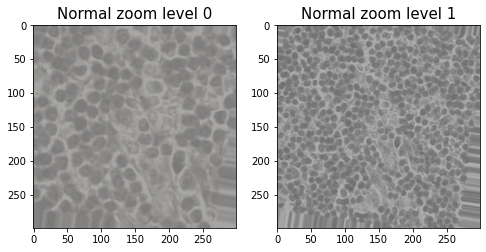

In [13]:
'''
quick sanity check on a random batch
'''
data, label = next(train_flow)
print(f"Level 0 shape is {data[0].shape}")
print(f"Level 1 shape is {data[1].shape}")
print(f"Label shape is {label.shape}")

random_ind = random.choice(range(len(label)))
if label[random_ind] == 0:
  prefix = 'Normal'
else:
  prefix = 'Tumor'

fig, ax = plt.subplots(1, 2, figsize=(8, 10))

ax[0].imshow(data[0][random_ind])
ax[0].set_title(f'{prefix} zoom level 0', size=15)
ax[1].imshow(data[1][random_ind])
ax[1].set_title(f'{prefix} zoom level 1', size=15)



plt.show()



**Build the model**

In [11]:
#build the model based on a given patch size
def build_model(patch_size=299):

  #two inception V3 on the top
  inception_level1 = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape = (patch_size, patch_size, 3))
  
  inception_level2 = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape = (patch_size, patch_size, 3))
  

  inception_level1.trainable = False
  inception_level2.trainable = False


  #build the base model
  model_zoom1 = Sequential()
  model_zoom1.add(inception_level1)
  model_zoom1.add(GlobalAveragePooling2D())


  model_zoom2 = Sequential()
  model_zoom2.add(inception_level2)
  model_zoom2.add(GlobalAveragePooling2D())


  input_zoom1 = Input(shape=(patch_size, patch_size, 3))
  input_zoom2 = Input(shape=(patch_size, patch_size, 3))

  encode_zoom1 = model_zoom1(input_zoom1)
  encode_zoom2 = model_zoom2(input_zoom2)


  merged = concatenate([encode_zoom1, encode_zoom2])

  dense1 = Dense(256, activation='relu')(merged)

  dropout_layer = Dropout(0.5)(dense1)

  dense2 = Dense(126, activation='relu')(dropout_layer)

  output = Dense(1, activation='sigmoid')(dense2)


  model = Model(inputs=[input_zoom1, input_zoom2], outputs=output)

  return model




  


  



In [12]:
model = build_model()

model.summary()


87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 2048)         21802784    ['input_3[0][0]']                
                             

<b>Visualize the model with plot_model()</b>


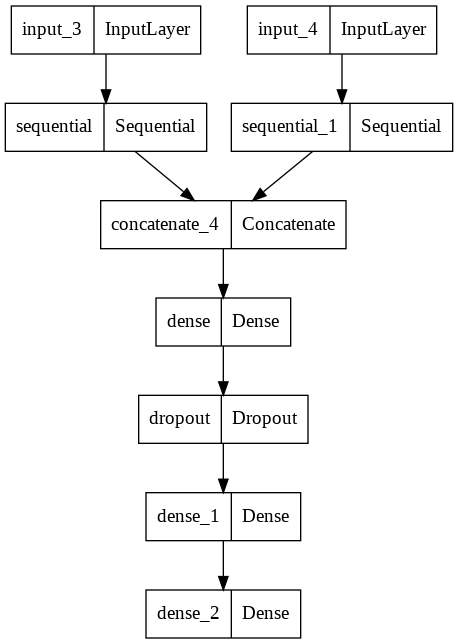

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='build_model.png')

**Train the model on a batch for sanity check**

In [13]:
model = build_model()

model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics = ['accuracy'])


In [52]:
#get data from first batch

(level1_img, level2_img), labels = next(train_flow)

In [53]:
#sanity check on one batch
for iter_idx in range(60):
  metrics = model.train_on_batch(x=[level1_img, level2_img], y=labels)

  if (iter_idx + 1)%10 == 0:
    print(f"Currently at {iter_idx+1}, with loss {metrics[0]} and accurary {metrics[1]}")

Currently at 10, with loss 0.31781139969825745 and accurary 0.875
Currently at 20, with loss 0.12561126053333282 and accurary 1.0
Currently at 30, with loss 0.04692460969090462 and accurary 1.0
Currently at 40, with loss 0.017584780231118202 and accurary 1.0
Currently at 50, with loss 0.010172989219427109 and accurary 1.0
Currently at 60, with loss 0.006783461198210716 and accurary 1.0


**Data passed sanity check, start to run on full train data set**

In [16]:
#set up checkpoints


batch_size = 16

#class_weights = {0:0.2, 1:0.8}


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

model = build_model()

model.compile(optimizer=Adam(learning_rate=0.0001),
                             loss='binary_crossentropy',
                             metrics = ['accuracy'])

history = model.fit(train_flow,
                              epochs=25,
                              validation_data=val_flow,
                              steps_per_epoch = len(train_data_level1) / batch_size,
                              validation_steps = len(val_data_level1) / batch_size)
                                                 #class_weight = class_weights)

Epoch 1/25
250/250 [==============================] - 153s 553ms/step - loss: 0.4167 - accuracy: 0.8062 - val_loss: 0.3160 - val_accuracy: 0.8687
Epoch 2/25
250/250 [==============================] - 135s 541ms/step - loss: 0.2643 - accuracy: 0.8940 - val_loss: 0.2844 - val_accuracy: 0.8825
Epoch 3/25
250/250 [==============================] - 135s 543ms/step - loss: 0.2366 - accuracy: 0.9060 - val_loss: 0.3030 - val_accuracy: 0.8888
Epoch 4/25
250/250 [==============================] - 134s 539ms/step - loss: 0.2201 - accuracy: 0.9125 - val_loss: 0.2814 - val_accuracy: 0.8813
Epoch 5/25
250/250 [==============================] - 134s 537ms/step - loss: 0.2046 - accuracy: 0.9165 - val_loss: 0.2940 - val_accuracy: 0.8938
Epoch 6/25
250/250 [==============================] - 135s 541ms/step - loss: 0.2004 - accuracy: 0.9237 - val_loss: 0.2741 - val_accuracy: 0.8988
Epoch 7/25
250/250 [==============================] - 134s 537ms/step - loss: 0.1964 - accuracy: 0.9200 - val_loss: 0.2398 -

<b>Save the trained model and history to pkl file</b>

In [2]:
#save trained model and history
with open("/content/drive/My Drive/120319_project_tumor_folder/20211227_trained_model_with_history_no_preprocessing.pkl", "wb") as f:
  pickle.dump([model, history], f)
f.close()

